# Installation and Mount Google Drive

In [1]:
!apt-get install -y swig
!pip install gymnasium[box2d] torch matplotlib numpy

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/Colab Notebooks/RL_HW3"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,430 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 125079 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

# Import Libraries Cell

In [18]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import argparse
import os
import imageio
import base64
import io
from IPython.display import HTML, display

# Define DQN Network

In [3]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)

# DQN Agent

In [5]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Policy network and target network
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(10000)

    def select_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()

    def update(self, batch_size):
        if len(self.memory) < batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Compute Q values
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q = self.target_net(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * self.gamma * next_q

        # Compute loss and update
        loss = nn.MSELoss()(current_q, target_q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Training Function

In [6]:
def train_agent(episodes=1000, batch_size=64, target_update=10):
    env = gym.make("LunarLander-v3")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)
    episode_rewards = []

    print("Starting training...")

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.memory.push(state, action, reward, next_state, done)
            agent.update(batch_size)

            state = next_state
            episode_reward += float(reward)

        agent.update_epsilon()

        if episode % target_update == 0:
            agent.update_target_net()

        episode_rewards.append(episode_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    env.close()

    # Save model to Google Drive
    model_path = '/content/drive/MyDrive/Colab Notebooks/RL_HW3/model.pth'
    torch.save(agent.policy_net.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    # Save training plot to Google Drive
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('LunarLander-v3 Training Curve (DQN)')
    plt.grid(True)
    plot_path = '/content/drive/MyDrive/Colab Notebooks/RL_HW3/train_plot.png'
    plt.savefig(plot_path)
    plt.show()
    print(f"Training plot saved to {plot_path}")

    return agent, episode_rewards

# Run Training

Starting training...
Episode 0, Avg Reward: -133.75, Epsilon: 0.995
Episode 10, Avg Reward: -249.74, Epsilon: 0.946
Episode 20, Avg Reward: -127.04, Epsilon: 0.900
Episode 30, Avg Reward: -116.67, Epsilon: 0.856
Episode 40, Avg Reward: -174.89, Epsilon: 0.814
Episode 50, Avg Reward: -102.99, Epsilon: 0.774
Episode 60, Avg Reward: -114.44, Epsilon: 0.737
Episode 70, Avg Reward: -100.01, Epsilon: 0.701
Episode 80, Avg Reward: -80.73, Epsilon: 0.666
Episode 90, Avg Reward: -62.58, Epsilon: 0.634
Episode 100, Avg Reward: -48.42, Epsilon: 0.603
Episode 110, Avg Reward: -95.75, Epsilon: 0.573
Episode 120, Avg Reward: -87.65, Epsilon: 0.545
Episode 130, Avg Reward: -65.49, Epsilon: 0.519
Episode 140, Avg Reward: -99.17, Epsilon: 0.493
Episode 150, Avg Reward: -36.10, Epsilon: 0.469
Episode 160, Avg Reward: -27.84, Epsilon: 0.446
Episode 170, Avg Reward: -37.42, Epsilon: 0.424
Episode 180, Avg Reward: -46.21, Epsilon: 0.404
Episode 190, Avg Reward: -72.59, Epsilon: 0.384
Episode 200, Avg Rewar

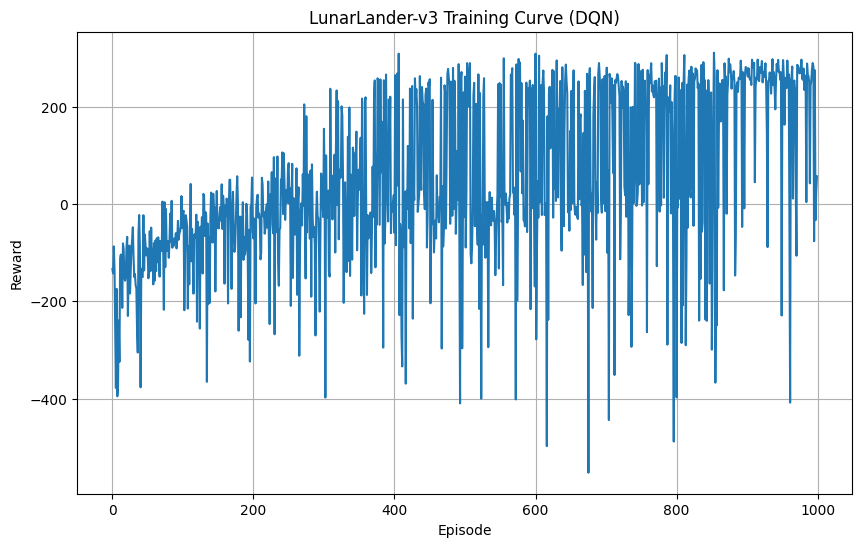

Training plot saved to /content/drive/MyDrive/Colab Notebooks/RL_HW3/train_plot.png
Training completed!


In [7]:
agent, rewards = train_agent(episodes=1000)
print("Training completed!")

# Test Function

In [35]:
import base64
import io
from IPython.display import HTML, display
import imageio

def test_agent(model_path='/content/drive/MyDrive/Colab Notebooks/RL_HW3/model.pth', episodes=3, save_video=True):
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN(state_dim, action_dim).to(device)
    policy_net.load_state_dict(torch.load(model_path, map_location=device))
    policy_net.eval()

    print("Testing trained model...")

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        frames = []

        while not done:

            frame = env.render()
            frames.append(frame)


            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                action = policy_net(state_tensor).argmax().item()

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += float(reward)

        print(f"Test Episode {episode + 1}, Reward: {episode_reward:.2f}")


        if save_video:
            video_path = f'/content/drive/MyDrive/Colab Notebooks/RL_HW3/test_episode_{episode+1}.mp4'
            imageio.mimsave(video_path, frames, fps=30)
            print(f"Video saved to {video_path}")


            if episode == 0:
                display_video(video_path)

    env.close()
    print("Testing completed!")

def display_video(video_path):
    """Display video in Colab notebook"""
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data='''
    <video width="600" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
    '''.format(encoded.decode('ascii'))))

# Run Test

In [44]:
test_agent('/content/drive/MyDrive/Colab Notebooks/RL_HW3/model.pth', episodes=3, save_video=True)

Testing trained model...


Test Episode 1, Reward: 2.19
Video saved to /content/drive/MyDrive/Colab Notebooks/RL_HW3/test_episode_1.mp4


Test Episode 2, Reward: 44.79
Video saved to /content/drive/MyDrive/Colab Notebooks/RL_HW3/test_episode_2.mp4


Test Episode 3, Reward: 281.39
Video saved to /content/drive/MyDrive/Colab Notebooks/RL_HW3/test_episode_3.mp4
Testing completed!
